In [32]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# File path
file_path = "BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)

In [3]:
# Filter and preprocess the data
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')]
filtered_text_data = filtered_text_data[filtered_text_data['Age'] != 'not available']
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', "Mask_tumor_filename", "Mask_other_filename", "Pixel_size", "Verification", "BIRADS"]]
filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

filtered_text_data.head(5)

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,combined_text
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,1 57 heterogeneous: predominantly fat breast s...
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,3 56 heterogeneous: predominantly fat no nippl...
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,4 43 homogeneous: fibroglandular no no round c...
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,5 67 homogeneous: fat nipple retraction&palpab...
5,6,case006.png,case006_tumor.png,NaN,0.007812,56,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,6 56 heterogeneous: predominantly fat no HRT/h...


In [4]:
# Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
# Generate text embeddings
text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")
text_embeddings = model.get_text_features(**text_inputs)

In [6]:
text_embeddings.shape

torch.Size([211, 512])

In [7]:
# Image feature extraction
def get_image_embedding(image_path, processor, model):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs)
    return image_embedding

In [34]:
import os
import zipfile

# Path to the zip file
zip_file_path = "/content/No_Age_Removed_BrEaST-Lesions_USG-images_and_masks.zip"

extracted_folder_path = "/content/No_Age_Removed_BrEaST-Lesions_USG-images_and_masks/No_Age_Removed_BrEaST-Lesions_USG-images_and_masks"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

image_embeddings = []
base_path = extracted_folder_path
for filename in filtered_text_data['Image_filename']:
    image_path = os.path.join(base_path, filename)
    embedding = get_image_embedding(image_path, processor, model)
    image_embeddings.append(embedding)

In [10]:
image_embeddings_tensor = torch.stack(image_embeddings).squeeze(-1)
image_embeddings_tensor = image_embeddings_tensor.view(image_embeddings_tensor.shape[0], -1)

In [11]:
image_embeddings_tensor.shape

torch.Size([211, 512])

In [12]:
# Prepare labels
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [13]:
# Convert embeddings to NumPy arrays
text_embeddings_np = text_embeddings.detach().numpy()
image_embeddings_np = image_embeddings_tensor.detach().numpy()

In [14]:
# Train-test split
text_train, text_test, img_train, img_test, y_train, y_test = train_test_split(
    text_embeddings_np, image_embeddings_np, encoded_labels, test_size=0.2, random_state=42
)

In [15]:
# Define text and image models
text_model_input = Input(shape=(text_train.shape[1],), name="text_input")
text_model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization()
])(text_model_input)

image_model_input = Input(shape=(img_train.shape[1],), name="image_input")
image_model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization()
])(image_model_input)

In [16]:
# Combine text and image models
combined_input = concatenate([text_model, image_model])
x = Dense(32, activation='relu')(combined_input)
x = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs=[text_model_input, image_model_input], outputs=x)

In [17]:
# Compile the model
final_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc'),
    ]
)

# Train the model
history = final_model.fit(
    [text_train, img_train], y_train, epochs=10, batch_size=32, validation_split=0.4, verbose=1
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.6150 - auc: 0.6564 - loss: 0.6622 - precision: 0.4544 - recall: 0.4660 - val_accuracy: 0.8088 - val_auc: 0.9153 - val_loss: 0.6304 - val_precision: 0.6579 - val_recall: 1.0000
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8103 - auc: 0.8568 - loss: 0.4832 - precision: 0.6993 - recall: 0.8382 - val_accuracy: 0.7794 - val_auc: 0.9763 - val_loss: 0.5750 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8167 - auc: 0.9333 - loss: 0.3822 - precision: 0.7683 - recall: 0.7828 - val_accuracy: 0.7206 - val_auc: 0.9893 - val_loss: 0.5365 - val_precision: 0.5682 - val_recall: 1.0000
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8659 - auc: 0.9546 - loss: 0.3140 - precision: 0.7596 - recall: 0.8799 - val_accuracy: 0.7647 - val_auc: 0.9958 - val_loss: 0.4956 - val_precision: 0.6098 - val_recall: 1.0000
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms

In [31]:
# Evaluate the model
test_loss, test_accuracy, test_auc, test_precision, test_recall = final_model.evaluate([text_test, img_test], y_test, verbose=1)

# Print the values
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9741 - auc: 0.9972 - loss: 0.2316 - precision: 1.0000 - recall: 0.9548
Test Loss: 0.22913573682308197
Test Accuracy: 0.9767441749572754
Test AUC: 1.0
Test Precision: 0.9599999785423279
Test Recall: 0.9977777600288391


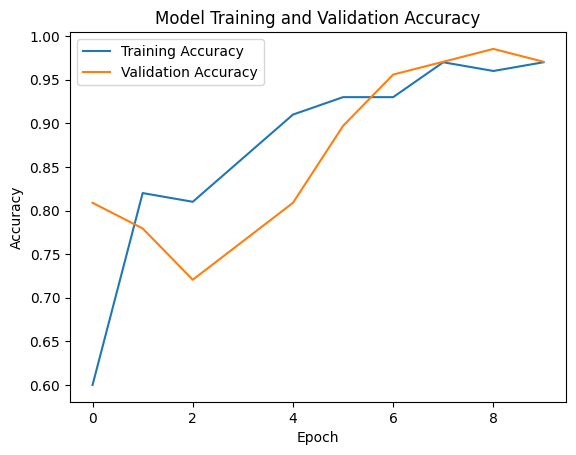

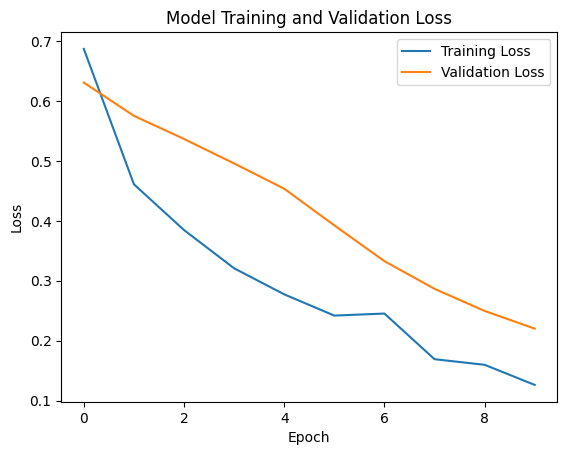

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [26]:
# Confusion matrix
y_pred = (final_model.predict([text_test, img_test]) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[18  0]
 [ 1 24]]
